In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os, time, gc, random, pickle
from sklearn.neighbors import NearestNeighbors
import requests, shutil
import tensorflow as tf
import keras

from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3

%matplotlib inline

Using TensorFlow backend.


# Load Data

In [2]:
train_df = pd.read_csv('./data/triplet/train.csv')
val_df = pd.read_csv('./data/triplet/validation.csv')
test_df = pd.read_csv('./data/triplet/test.csv')

print('Train:\t\t', train_df.shape)
print('Validation:\t', val_df.shape)
print('Test:\t\t', test_df.shape)

print('\nTrain Landmarks:\t', len(train_df['landmark_id'].unique()))
print('Validation Landmarks:\t', len(val_df['landmark_id'].unique()))
print('Test Landmarks:\t\t', len(test_df['landmark_id'].unique()))

Train:		 (113783, 4)
Validation:	 (22255, 4)
Test:		 (22391, 4)

Train Landmarks:	 14943
Validation Landmarks:	 7674
Test Landmarks:		 14436


In [3]:
train_df.head()

,image_id,id,url,landmark_id
0,465272,a2ccf8ed2e969f6a,https://lh4.googleusercontent.com/-TPHkS5gzvm4...,0
1,64516,e205ca7c8dd7c027,https://lh3.googleusercontent.com/-V3RjsZtGpxE...,0
2,928409,4e8ab93c1620e8a3,http://mw2.google.com/mw-panoramio/photos/medi...,0
3,88809,896bf928214d1ca4,http://lh5.ggpht.com/-Cy0l41uUaGA/R--yB8vy41I/...,0
4,1001133,375d2a153bdca926,http://lh6.ggpht.com/-UqzFpnqE9bU/S_0u1RovfdI/...,0


# Helper Functions

In [4]:
# training set triplet generator
def train_triplet_generator(df, batch_size=100, img_size=(224, 224), seed=42, 
                            prefix='./data/triplet/train/'):
    """ training set triplet generator
        it will generate 7400 triplet images in total
    """
    # get images with only one training image landmark id and the rest landmark ids
    np.random.seed(seed)
    grouped = df[['landmark_id', 'image_id']].groupby('landmark_id').count().reset_index()
    unique_neg_ids = list(grouped[grouped['image_id'] == 1]['landmark_id'].values)
    rest_ids = list(grouped[grouped['image_id'] > 1]['landmark_id'].values)
    size = 7400 * 2 - len(unique_neg_ids) 
    zeros = np.zeros((batch_size, 3, 1), dtype=K.floatx())
    
    while True:
        # get positive and negative image landmark ids
        np.random.shuffle(rest_ids)
        candidate_ids = list(np.random.choice(rest_ids, size=size, replace=False))
        pos_landmark_ids = candidate_ids[:7400]
        neg_landmark_ids = candidate_ids[7400:] + unique_neg_ids
        np.random.shuffle(neg_landmark_ids)
        
        # transform landmark id into image id
        anc_img_ids = []
        pos_img_ids = []
        neg_img_ids = []
        
        for i in range(len(pos_landmark_ids)):
            tmp_pos_ids = df[df['landmark_id'] == pos_landmark_ids[i]]['image_id'].values
            anc_img_ids.append(tmp_pos_ids[0])
            pos_img_ids.append(tmp_pos_ids[1])
            
            tmp_neg_ids = df[df['landmark_id'] == neg_landmark_ids[i]]['image_id'].values
            neg_img_ids.append(tmp_neg_ids[0])
        
        # iterator to read batch images
        for j in range(len(pos_img_ids) // batch_size):
            batch_anc_img_ids = anc_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_pos_img_ids = pos_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_neg_img_ids = neg_img_ids[j * batch_size: (j + 1) * batch_size]
            
            # get images
            anc_imgs = []
            pos_imgs = []
            neg_imgs = []
            
            # iteratively read images
            for k in range(batch_size):
                anc_path = prefix + str(batch_anc_img_ids[k]) + '.jpg'
                pos_path = prefix + str(batch_pos_img_ids[k]) + '.jpg'
                neg_path = prefix + str(batch_neg_img_ids[k]) + '.jpg'
                
                tmp_anc_img = load_img(anc_path, target_size=img_size)
                tmp_anc_img = img_to_array(tmp_anc_img)
                anc_imgs.append(tmp_anc_img)
                
                tmp_pos_img = load_img(pos_path, target_size=img_size)
                tmp_pos_img = img_to_array(tmp_pos_img)
                pos_imgs.append(tmp_pos_img)
                
                tmp_neg_img = load_img(neg_path, target_size=img_size)
                tmp_neg_img = img_to_array(tmp_neg_img)
                neg_imgs.append(tmp_neg_img)
        
            # transform list to array
            anc_imgs = np.array(anc_imgs, dtype=K.floatx()) / 255.0
            pos_imgs = np.array(pos_imgs, dtype=K.floatx()) / 255.0
            neg_imgs = np.array(neg_imgs, dtype=K.floatx()) / 255.0

            yield [anc_imgs, pos_imgs, neg_imgs], zeros

In [5]:
# validation set triplet generator
def val_triplet_generator(df, batch_size=128, img_size=(224, 224), 
                          seed=42, prefix='./data/triplet/validation'):
    """ validation set triplet collector """
    
     # get images with only one image landmark id and the rest landmark ids
    grouped = df[['landmark_id', 'image_id']].groupby('landmark_id').count().reset_index()
    unique_neg_ids = list(grouped[grouped['image_id'] == 1]['landmark_id'].values)
    rest_ids = list(grouped[grouped['image_id'] > 1]['landmark_id'].values)
    size = 3072 * 2 - len(unique_neg_ids) 
    zeros = np.zeros((batch_size, 3, 1), dtype=K.floatx())
    
    while True:
        # get positive and negative image landmark ids
        np.random.seed(seed)
        candidate_ids = list(np.random.choice(rest_ids, size=size, replace=False))
        pos_landmark_ids = candidate_ids[:3072]
        neg_landmark_ids = candidate_ids[3072:] + unique_neg_ids
        np.random.shuffle(neg_landmark_ids)
        
        # transform landmark id into image id
        anc_img_ids = []
        pos_img_ids = []
        neg_img_ids = []
        
        for i in range(len(pos_landmark_ids)):
            tmp_pos_ids = df[df['landmark_id'] == pos_landmark_ids[i]]['image_id'].values
            anc_img_ids.append(tmp_pos_ids[0])
            pos_img_ids.append(tmp_pos_ids[1])
            
            tmp_neg_ids = df[df['landmark_id'] == neg_landmark_ids[i]]['image_id'].values
            neg_img_ids.append(tmp_neg_ids[0])
        
        # iterator to read batch images
        for j in range(len(pos_img_ids) // batch_size):
            batch_anc_img_ids = anc_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_pos_img_ids = pos_img_ids[j * batch_size: (j + 1) * batch_size]
            batch_neg_img_ids = neg_img_ids[j * batch_size: (j + 1) * batch_size]
            
            # get images
            anc_imgs = []
            pos_imgs = []
            neg_imgs = []
            
            # iteratively read images
            for k in range(batch_size):
                anc_path = prefix + str(batch_anc_img_ids[k]) + '.jpg'
                pos_path = prefix + str(batch_pos_img_ids[k]) + '.jpg'
                neg_path = prefix + str(batch_neg_img_ids[k]) + '.jpg'
                
                tmp_anc_img = load_img(anc_path, target_size=img_size)
                tmp_anc_img = img_to_array(tmp_anc_img)
                anc_imgs.append(tmp_anc_img)
                
                tmp_pos_img = load_img(pos_path, target_size=img_size)
                tmp_pos_img = img_to_array(tmp_pos_img)
                pos_imgs.append(tmp_pos_img)
                
                tmp_neg_img = load_img(neg_path, target_size=img_size)
                tmp_neg_img = img_to_array(tmp_neg_img)
                neg_imgs.append(tmp_neg_img)
        
            # transform list to array
            anc_imgs = np.array(anc_imgs, dtype=K.floatx()) / 255.0
            pos_imgs = np.array(pos_imgs, dtype=K.floatx()) / 255.0
            neg_imgs = np.array(neg_imgs, dtype=K.floatx()) / 255.0
            
            yield [anc_imgs, pos_imgs, neg_imgs], zeros

# Define Triplet Loss Model

In [6]:
# Define base network for triplet network
def base_net(input_shape=(224, 224, 3)):
    """ define triplet network """
    # load pre-trained InceptionV3 model
    inception = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    
    # frozen shallow layers
    inception.trainable = True
    
    set_trainable = False
    for layer in inception.layers:
        if layer.name == 'mixed9':
            set_trainable = True
            
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    # define sequential model
    model = Sequential(name='base_net')
    model.add(inception)
    model.add(Lambda(lambda x: K.l2_normalize(x, axis=1), name='l2_norm'))
    
    return model

In [7]:
# Define triplet network
def triplet_net(base_model, input_shape=(224, 224, 3)):
    """ function to define triplet networks """
    # define input: anchor, positive, negative
    anchor = Input(shape=input_shape, name='anchor_input')
    positive = Input(shape=input_shape, name='positive_input')
    negative = Input(shape=input_shape, name='negative_input')
    
    # extract vector represent using CNN based model
    anc_vec = base_model(anchor)
    pos_vec = base_model(positive)
    neg_vec = base_model(negative)
    
    # stack outputs
    stacks = Lambda(lambda x: K.stack(x, axis=1), name='output')([anc_vec, pos_vec, neg_vec])

    # define inputs and outputs
    inputs=[anchor, positive, negative]
    outputs = stacks
    
    # define the triplet model
    model = Model(inputs=inputs, outputs=outputs, name='triplet_net')
    
    return model

In [8]:
# Define triplet loss
def triplet_loss(y_true, y_pred):
    """ function to compute triplet loss
        margin is predefined coded, manually change if needed
    """
    # define triplet margin
    margin = K.constant(0.4)
    zero = K.constant(0.0)
    
    # get the prediction vector
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    
    # compute distance
    pos_distance = K.sum(K.square(anchor - positive), axis=1)
    neg_distance = K.sum(K.square(anchor - negative), axis=1)
    
    # compute loss
    partial_loss = pos_distance - neg_distance + margin
    full_loss = K.sum(K.maximum(partial_loss, zero), axis=0)
    
    return full_loss

# Build Triplet Model

In [9]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define Parameters
img_size = (224, 224, 3)  # target image size

# triplet image generator
train_generator = train_triplet_generator(train_df, batch_size=100, img_size=img_size[:2], 
                                          seed=42, prefix='./data/triplet/train/')

val_generator = val_triplet_generator(val_df, batch_size=64, img_size=img_size[:2], 
                                      seed=42, prefix='./data/triplet/validation/')

In [10]:
# Define triplet network model
base_model = base_net(input_shape=img_size)
base_model.summary()

Instructions for updating:
dim is deprecated, use axis instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
l2_norm (Lambda)             (None, 2048)              0         
Total params: 21,802,784
Trainable params: 6,073,536
Non-trainable params: 15,729,248
_________________________________________________________________


In [11]:
triplet_model = triplet_net(base_model=base_model, input_shape=img_size)
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
base_net (Sequential)           (None, 2048)         21802784    anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

# Fit Triplet Model

In [12]:
# define learning scheduler
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 80:
        lr *= 2e-1
    elif epoch > 60:
        lr *= 4e-1
    elif epoch > 40:
        lr *= 6e-1
    elif epoch > 20:
        lr *= 8e-1
    print('Learning rate: ', lr)
    return lr

# define optimizer
opt = keras.optimizers.Adam(lr=lr_schedule(0))

# Create call backs
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [lr_reducer, lr_scheduler]

# compile the model
triplet_model.compile(optimizer=opt, loss=triplet_loss)

Learning rate:  0.001


In [13]:
# fit the mode
history = triplet_model.fit_generator(train_generator, steps_per_epoch=74, epochs=100, 
                                      validation_data=val_generator, validation_steps=48, 
                                      verbose=2, callbacks=callbacks)

base_model.save('./models/inception-base-0.4-model.h5')
pickle.dump(history.history, open('./models/inception-triplet-0.4-history.p', 'wb'))
_ = gc.collect()

Epoch 1/100
Learning rate:  0.001
 - 72s - loss: 9.4577 - val_loss: 5.4752
Epoch 2/100
Learning rate:  0.001
 - 51s - loss: 5.2701 - val_loss: 5.0196
Epoch 3/100
Learning rate:  0.001
 - 52s - loss: 4.1987 - val_loss: 4.6280
Epoch 4/100
Learning rate:  0.001
 - 51s - loss: 3.9098 - val_loss: 5.0792
Epoch 5/100
Learning rate:  0.001
 - 51s - loss: 3.3303 - val_loss: 4.9101
Epoch 6/100
Learning rate:  0.001
 - 51s - loss: 2.7693 - val_loss: 4.8455
Epoch 7/100
Learning rate:  0.001
 - 51s - loss: 2.6522 - val_loss: 4.3390
Epoch 8/100
Learning rate:  0.001
 - 51s - loss: 2.3822 - val_loss: 4.8301
Epoch 9/100
Learning rate:  0.001
 - 52s - loss: 2.3149 - val_loss: 4.3806
Epoch 10/100
Learning rate:  0.001
 - 51s - loss: 1.8642 - val_loss: 4.1901
Epoch 11/100
Learning rate:  0.001
 - 52s - loss: 2.0404 - val_loss: 4.4720
Epoch 12/100
Learning rate:  0.001
 - 52s - loss: 1.8926 - val_loss: 4.4903
Epoch 13/100
Learning rate:  0.001
 - 51s - loss: 1.6310 - val_loss: 4.2339
Epoch 14/100
Learning

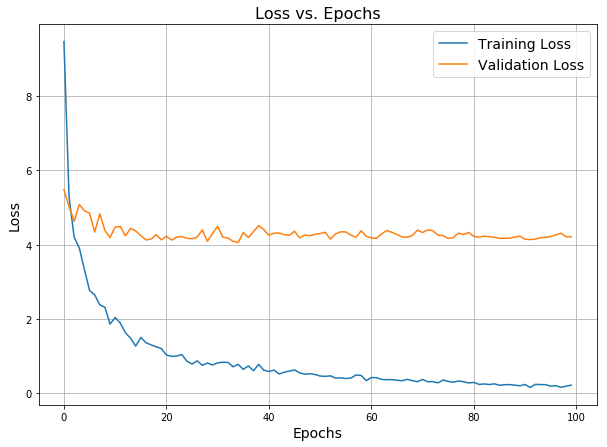

In [14]:
# Visualize the training process
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.show()

# Extract Features using Triplet Network

In [15]:
train_df = pd.read_csv('./data/triplet/train.csv')
val_df = pd.read_csv('./data/triplet/validation.csv')
test_df = pd.read_csv('./data/triplet/test.csv')

print('Train:\t\t', train_df.shape)
print('Validation:\t', val_df.shape)
print('Test:\t\t', test_df.shape)

print('\nTrain Landmarks:\t', len(train_df['landmark_id'].unique()))
print('Validation Landmarks:\t', len(val_df['landmark_id'].unique()))
print('Test Landmarks:\t\t', len(test_df['landmark_id'].unique()))

Train:		 (113783, 4)
Validation:	 (22255, 4)
Test:		 (22391, 4)

Train Landmarks:	 14943
Validation Landmarks:	 7674
Test Landmarks:		 14436


In [16]:
# Load trained model
base_model = load_model('./models/inception-base-0.4-model.h5')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
l2_norm (Lambda)             (None, 2048)              0         
Total params: 21,802,784
Trainable params: 6,073,536
Non-trainable params: 15,729,248
_________________________________________________________________


In [17]:
# Define train_imgs and test_imgs
train_imgs = np.zeros(shape=(len(train_df), 2048), dtype=np.float32)
val_imgs = np.zeros(shape=(len(val_df), 2048), dtype=np.float32)
test_imgs = np.zeros(shape=(len(test_df), 2048), dtype=np.float32)

In [18]:
# Process training images
img_ids = train_df['image_id'].values
steps = 20000
for i in range(0, len(train_df), steps):
    tmp_imgs = []
    print('\nProcess: {:10d}'.format(i))
    
    start = i
    end = min(len(train_df), i + steps)
    for idx in range(start, end):
        if idx % 250 == 0:
            print('=', end='')
            
        img_id = img_ids[idx]
        path = './data/triplet/train/' + str(img_id) + '.jpg'
        img = load_img(path, target_size=img_size[:2])
        img = img_to_array(img)
        tmp_imgs.append(img)
        
    tmp_imgs = np.array(tmp_imgs, dtype=np.float32) / 255.0
    tmp_prediction = base_model.predict(tmp_imgs)
    train_imgs[start: end, ] = tmp_prediction
    _ = gc.collect()


Process:          0
Process:      20000
Process:      40000
Process:      60000
Process:      80000
Process:     100000

In [19]:
# Process validation images
img_ids = val_df['image_id'].values
steps = 4000
for i in range(0, len(val_df), steps):
    tmp_imgs = []
    print('\nProcess: {:10d}'.format(i))
    
    start = i
    end = min(len(val_df), i + steps)
    for idx in range(start, end):
        if idx % 50 == 0:
            print('=', end='')
            
        img_id = img_ids[idx]
        path = './data/triplet/validation/' + str(img_id) + '.jpg'
        img = load_img(path, target_size=img_size[:2])
        img = img_to_array(img)
        tmp_imgs.append(img)
        
    tmp_imgs = np.array(tmp_imgs, dtype=np.float32) / 255.0
    tmp_prediction = base_model.predict(tmp_imgs)
    val_imgs[start: end, ] = tmp_prediction
    _ = gc.collect()


Process:          0
Process:       4000
Process:       8000
Process:      12000
Process:      16000
Process:      20000

In [20]:
# Process test images
img_ids = test_df['image_id'].values
steps = 4000
for i in range(0, len(test_df), steps):
    tmp_imgs = []
    print('\nProcess: {:10d}'.format(i))
    
    start = i
    end = min(len(test_df), i + steps)
    for idx in range(start, end):
        if idx % 50 == 0:
            print('=', end='')
            
        img_id = img_ids[idx]
        path = './data/triplet/test/' + str(img_id) + '.jpg'
        img = load_img(path, target_size=img_size[:2])
        img = img_to_array(img)
        tmp_imgs.append(img)
        
    tmp_imgs = np.array(tmp_imgs, dtype=np.float32) / 255.0
    tmp_prediction = base_model.predict(tmp_imgs)
    test_imgs[start: end, ] = tmp_prediction
    _ = gc.collect()


Process:          0
Process:       4000
Process:       8000
Process:      12000
Process:      16000
Process:      20000

In [21]:
print('Train:\t\t', train_imgs.shape)
print('Validation:\t', val_imgs.shape)
print('Test:\t\t', test_imgs.shape)

Train:		 (113783, 2048)
Validation:	 (22255, 2048)
Test:		 (22391, 2048)


In [22]:
# Save to disk
np.save('./data/triplet/train-triplet-inception-0.4-features.npy', train_imgs)
np.save('./data/triplet/validation-triplet-inception-0.4-features.npy', val_imgs)
np.save('./data/triplet/test-triplet-inception-0.4-features.npy', test_imgs)

# Load Features and Labels

In [23]:
# Already normalized
train_feature = np.load('./data/triplet/train-triplet-inception-0.4-features.npy')
val_feature = np.load('./data/triplet/validation-triplet-inception-0.4-features.npy')
test_feature = np.load('./data/triplet/test-triplet-inception-0.4-features.npy')

train_df = pd.read_csv('./data/triplet/train.csv')
val_df = pd.read_csv('./data/triplet/validation.csv')
test_df = pd.read_csv('./data/triplet/test.csv')

print('Train:\t\t', train_feature.shape, train_df.shape)
print('Validation:\t', val_feature.shape, val_df.shape)
print('Test:\t\t', test_feature.shape, test_df.shape)

Train:		 (113783, 2048) (113783, 4)
Validation:	 (22255, 2048) (22255, 4)
Test:		 (22391, 2048) (22391, 4)


In [24]:
# Helper function
def accuracy(true_label, prediction, top=1):
    """ function to calculate the prediction accuracy """
    prediction = prediction[:, :top]
    count = 0
    for i in range(len(true_label)):
        if true_label[i] in prediction[i]:
            count += 1
            
    return count / len(true_label)

# Implement KNN Model

In [25]:
# Merge train and validation features
train_val_feature = np.concatenate((train_feature, val_feature), axis=0)
train_val_df = pd.concat((train_df, val_df), axis=0)
train_val_df = train_val_df.reset_index(drop=True)

In [26]:
# Implement KNN model
knn = NearestNeighbors(n_neighbors=50, algorithm='auto', leaf_size=30, 
                       metric='minkowski', p=2, n_jobs=-1)
knn.fit(train_val_feature)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=-1, n_neighbors=50, p=2, radius=1.0)

In [27]:
# Search the first 50 neighbors
distance, neighbor_index = knn.kneighbors(test_feature, return_distance=True)

# Save the results
np.save('./result/knn-triplet-inception-0.4-distance.npy', distance)
np.save('./result/knn-triplet-inception-0.4-neighbor.npy', neighbor_index)

### Search Neighbors

In [28]:
knn_distance = np.load('./result/knn-triplet-inception-0.4-distance.npy')
knn_neighbor = np.load('./result/knn-triplet-inception-0.4-neighbor.npy')

# Get the first 50 neighbors
predictions = []
for neighbors in knn_neighbor:
    predictions.append(train_val_df.loc[neighbors]['landmark_id'].values)

predictions = np.array(predictions)
np.save('./result/knn-triplet-inception-0.4-test-prediction.npy', predictions)

### Compute Accuracy

In [29]:
print('Top  1 accuracy:\t', accuracy(test_df['landmark_id'].values, predictions, top=1))
print('Top  5 accuracy:\t', accuracy(test_df['landmark_id'].values, predictions, top=5))
print('Top 10 accuracy:\t', accuracy(test_df['landmark_id'].values, predictions, top=10))
print('Top 20 accuracy:\t', accuracy(test_df['landmark_id'].values, predictions, top=20))

Top  1 accuracy:	 0.3671564467866554
Top  5 accuracy:	 0.5336072529141173
Top 10 accuracy:	 0.603948014827386
Top 20 accuracy:	 0.6738868295297218


In [30]:
knn_acc = []
for i in range(1, 51):
    tmp_acc = accuracy(test_df['landmark_id'].values, predictions, top=i)
    knn_acc.append(tmp_acc)

np.save('./result/knn-triplet-inception-0.4-accuracy.npy', knn_acc)